# TensorFlow

## Sobre TensoFlow

[TensorFlow](https://www.tensorflow.org/) es una biblioteca open source desarrollada por Google que nos permite realizar cálculos numéricos usando diagramas de flujo de datos. Los nodos del gráfico representan operaciones matemáticas, mientras que los bordes del gráfico representan los arreglos de datos multidimensionales (tensores) comunicados entre ellos. Esta arquitectura flexible le permite realizar los cálculos en más de un CPU o GPU utilizando la misma API.

## ¿Qué es un diagrama de flujo de datos?

Los diagramas de flujo de datos describen cálculos matemáticos con un gráfico de direcciones de nodos y bordes. Los nodos normalmente implementan operaciones matemáticas, pero también pueden representar los puntos para alimentarse de datos, devolver resultados, o leer / escribir variables persistentes. Los bordes describen las relaciones de entrada / salida entre los nodos. Estos bordes están representados por los arreglos de datos multidimensionales o tensores. El flujo de los tensores a través del gráfico es de donde [TensorFlow](https://www.tensorflow.org/) recibe su nombre. Los nodos se asignan a los dispositivos computacionales y se ejecutan de forma asincronica y en paralelo una vez que todos los tensores en los bordes de entrada están disponibles.

<img src="https://www.tensorflow.org/images/tensors_flowing.gif">

In [1]:
# importamos librerias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

## Ejemplos de TensorFlow con MNIST dataset


## MNIST dataset

[MNIST](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) es un simple conjunto de datos para reconocimiento de imágenes por computadora. Se compone de imágenes de dígitos escritos a mano como los siguientes:

<img src="https://www.tensorflow.org/versions/r0.8/images/MNIST.png">

Para más información sobre el dataset visitar el siguiente [enlace](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)

In [2]:
# importando el dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Explorando MNIST dataset

In [3]:
# forma del dataset 55000 imagenes
mnist.train.images.shape

(55000, 784)

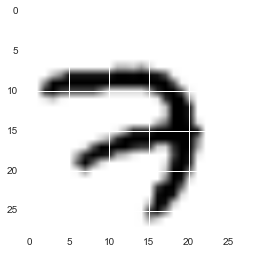

In [5]:
# cada imagen es un array de 28x28 con cada pixel 
# definido como escala de grises.
digito1 = mnist.train.images[0].reshape((28, 28))

# visualizando el primer digito
plt.imshow(digito1, cmap = cm.Greys)
plt.show()

In [6]:
# valor correcto
mnist.train.labels[0].nonzero()[0][0]

7

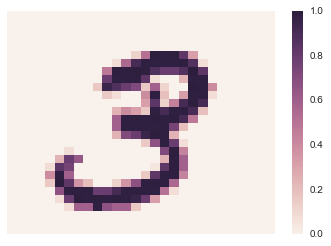

In [7]:
# 2da imagen como escala de grises
sns.heatmap(mnist.train.images[1].reshape((28, 28)), linewidth=0,
            xticklabels=False, yticklabels=False)
plt.show()

In [8]:
# valor correcto
mnist.train.labels[1].nonzero()[0][0]

3

In [9]:
# visualizando imagenes de 5 en 5
def visualizar_imagenes(dataset, cant_img):
    img_linea = 5
    lineas = int(cant_img / img_linea)
    imagenes = []
    for i in range(lineas):
        datos = []
        for img in dataset[img_linea* i:img_linea* (i+1)]:
            datos.append(img.reshape((28,28)))
            imgs = np.hstack(datos)
        imagenes.append(imgs)
    data = np.vstack(imagenes)
    plt.imshow(data, cmap = cm.Greys )
    plt.show()

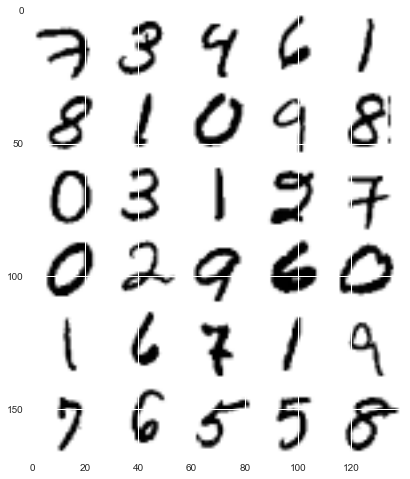

In [10]:
# visualizando los primeros 30 dígitos
plt.figure(figsize=(8, 8))
visualizar_imagenes(mnist.train.images, 30)

## Ejemplo con Regresión Softmax

La [regresión softmax](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica_multinomial) es una generalización del clásico modelo de [regresión logística](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica) para los casos en que tenemos que clasificar más de dos *clases*. Con [TensorFlow](https://www.tensorflow.org/) se puede implementar de forma muy sencilla. 

In [11]:
# Parametros
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1
logs_path = '/home/raul/python/notebooks/tensorflow_logs/regresion'

# Grafo de entrada
# mnist dataset contiene 55000 img de 28*28=784 pixeles cada una.
x = tf.placeholder(tf.float32, [None, 784], name='DatosEntrada')
# 0-9 digitos => 10 clases
y = tf.placeholder(tf.float32, [None, 10], name='Clases')

# Definiendo pesos y sesgo
W = tf.Variable(tf.zeros([784, 10]), name='Pesos')
b = tf.Variable(tf.zeros([10]), name='Sesgo')

In [12]:
# Construyendo el modelo y encapsulando cada etapa para crear el 
# grafico de Tensorboard.
with tf.name_scope('Modelo'):
    # Model
    pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax
with tf.name_scope('Perdida'):
    # Minimizar error con entropia cruzada.
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
with tf.name_scope('SGD'):
    # Optimizar con Gradiente descendiente
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Precision'):
    # Precisión
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Inicializando las variables
init = tf.initialize_all_variables()

# Creando los graficos sumarizados para monitoriar el comportamiento
tf.scalar_summary("Perdida", cost)
tf.scalar_summary("Precision", acc)
# incuir todo en una sola op.
merged_summary_op = tf.merge_all_summaries()

In [13]:
# Comenzar la sesion del grafo
with tf.Session() as sess:
    sess.run(init)

    # Escribir el Tensorboard
    summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

    # ciclo de entrenamiento
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Iterando por cada lote
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Ejecutar op de optimización y la op de cost
            # Ejecutar las sumarizaciones para el board
            _, c, summary = sess.run([optimizer, cost, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys})
            # Escribir el log por cada iteración
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Calculo de la perdida
            avg_cost += c / total_batch
        # imprimir valor de costo en cada etapa
        if (epoch+1) % display_step == 0:
            print("Iteración: {0: 04d} costo = {1:.9f}".format(epoch+1, 
                                                            avg_cost))
    print("Optimización Terminada!\n")


    # Evaluando el modelo
    # Calcular Precisión.
    print("Precisión: {0: .2f}".format(acc.eval({x: mnist.test.images, 
                                                y: mnist.test.labels})))

    print("Ejecutar el comando:\n",
          "--> tensorboard --logdir=/home/raul/python/notebooks/tensorflow_logs ",
          "\nLuego abir http://0.0.0.0:6006/ en el navegador")

Iteración:  001 costo = 1.182138982
Iteración:  002 costo = 0.664666365
Iteración:  003 costo = 0.552556451
Iteración:  004 costo = 0.498552143
Iteración:  005 costo = 0.465461540
Iteración:  006 costo = 0.442511582
Iteración:  007 costo = 0.425486782
Iteración:  008 costo = 0.412152169
Iteración:  009 costo = 0.401351124
Iteración:  010 costo = 0.392360673
Iteración:  011 costo = 0.384726642
Iteración:  012 costo = 0.378115484
Iteración:  013 costo = 0.372305323
Iteración:  014 costo = 0.367222529
Iteración:  015 costo = 0.362730414
Iteración:  016 costo = 0.358587650
Iteración:  017 costo = 0.354894436
Iteración:  018 costo = 0.351459428
Iteración:  019 costo = 0.348287457
Iteración:  020 costo = 0.345393356
Iteración:  021 costo = 0.342739379
Iteración:  022 costo = 0.340250473
Iteración:  023 costo = 0.337945684
Iteración:  024 costo = 0.335735816
Iteración:  025 costo = 0.333717388
Optimización Terminada!

Precisión:  0.91
Ejecutar el comando:
 --> tensorboard --logdir=/home/raul/

# Visualización de Precisión y función de perdida

<img src="http://relopezbriega.github.io/images/TensorBoard.png">

# Visualización del grafo de TensorFlow

<img src="http://relopezbriega.github.io/images/TensorBoard_grafo.png">